# Investigating the relationship between dollar signs and review trends

## Importing packages

In [1]:
#import the python scientific suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn
import seaborn as sns
import scipy
import pylab
import statsmodels

from sklearn.cross_validation import *
from sklearn import svm, linear_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree

from textblob import TextBlob

import statsmodels.api as sm
from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
#plot figures inline in Jupyter notebooks
%matplotlib inline 

#use seaborn for plotting
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [2]:
def WordCount(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

def Polarity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.polarity

def Subjectivity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.subjectivity

#define some helper functions 
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)
def BootstrapDataframe(df):
    resample_i = np.floor(np.random.rand(len(df))*len(df)).astype(int)
    return(df.iloc[resample_i])


def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            w = scipy.stats.norm.pdf((df[x] - bc)/(eps))
            if sum(w) != 0.0:
                rolling.append((bc, np.average(df[y], weights = w))) #take the mean and add it to the stack
            else:
                rolling.append((bc, np.average(df[y])))
    return(pd.DataFrame(rolling).rename(columns = {0: 'x', 1: 'y'}))
def train_and_evaluate(clf, X_train, y_train, verbose = False):
        
    clf.fit(X_train, y_train) #fit the model

    #create a k-fold cross validation iterator of k = 5 folds

    cv = KFold(X_train.shape[0], 5, shuffle = True)
    scores = cross_val_score(clf, X_train, y_train, cv = cv)

    if verbose == True: #if we want to print status
        print("Coefficient of determination on training set:", clf.score(X_train, y_train))
        print("Average coefficient of determination using 5-fold crossvalidation:", np.mean(scores))
    
    return clf.score(X_train, y_train), np.mean(scores)

def OneDimensionalROC(clf, X_train, y_train, X_test):
    
    pylab.rcParams['figure.figsize'] = (6.0, 6.0)
    
    #debate differences between decision function and predict_proba?
    #they are inverse monotone
    
    #y_score = clf.fit(X_train, y_train).decision_function(X_test)
    y_score = clf.fit(X_train, y_train).predict_proba(X_test).T[1]

    n_classes = 1 #this is a single class classification problem

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, y_score
def SelectMultipleWLS(df, y_col, x_col, id_list, id_name, name, fdr = 0.1):
    
    fit_params = defaultdict(list)

    for ids in id_list: #for the unique business IDs, i.e. for each neighborhood
        
        f = df[df[id_name] == ids][[x_col,y_col]] #create a review dataframe that is just for that neighborhood
        wls = sm.WLS(f[y_col],sm.add_constant(f[x_col])).fit()
        
        fit_params[id_name].append(ids)
        fit_params[name + '_slope'].append(wls.params[x_col])
        fit_params[name + '_p_value'].append(wls.pvalues[x_col])
        fit_params[name + '_slope_err'].append(wls.bse[x_col])
        fit_params[name + '_mean'].append(np.mean(f[y_col]))
    
    fit_params = pd.DataFrame(fit_params)

    fit_params[name + '_c_hyp'], fit_params[name + '_c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(fit_params[name + '_p_value'],\
                                                  method = 'fdr_bh', alpha = fdr)
        
    return fit_params

def InCategory(string_list, string):
    if string in string_list:
        out = 1
    else:
        out = 0
    return out

## Reading in the files:

In [33]:
#read in the data from the files
file_dir = '/Users/zihaoxu/Desktop/Pomona/2017_Spring/Data Science Research/yz_data/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business_2.csv', 'U': 'U_user.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(d.keys()) #the list of files in the data dictionary

dict_keys(['B', 'R', 'U', 'N', 'T'])


In [35]:
#begin filtration of data based on multiple criteria
min_reviews_per_business = 3
min_reviews_per_user = 5
min_business_per_neighborhood = 0

#perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]
d['U'] = d['U'][(d['U']['n_reviews'] >= min_reviews_per_user)]
d['N'] = d['N'][(d['N']['n'] >= min_business_per_neighborhood)]

# Visualizing the review trend

In [36]:
d['RB'] = pd.merge(d['R'], d['B'][['business_id', 'Price']], on = ['business_id'])
d['NRB'] = pd.merge(d['RB'], d['N'][['n','z_hood','state']], on = ['z_hood'], how = 'left').dropna()
ottf_list = [1,2,3,4]
quartile_wls = pd.DataFrame({'quartile':ottf_list})
# add a column to d['NRB'] to indicate the quartile
d['NRB']['quartile']= pd.qcut(d['NRB']['latest_zhvi'], 4, labels=False)+1

In [47]:
price_list = [1.0, 2.0, 3.0, 4.0]
quartile_list = ['25%', '50%', '75%','max']
color_list = ['blue', 'g','r','purple'] # color of each dollar sign
state_list = ['AZ', 'NV', 'WI', 'PA', 'NC'] # color of each dollar sign


for price in price_list:
    print("Number of reviews w/ ", str(price), "dollar signs: ", str(len(d['NRB'][d['NRB']['Price']==price])))

Number of reviews w/  1.0 dollar signs:  205622
Number of reviews w/  2.0 dollar signs:  447046
Number of reviews w/  3.0 dollar signs:  54502
Number of reviews w/  4.0 dollar signs:  6624


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


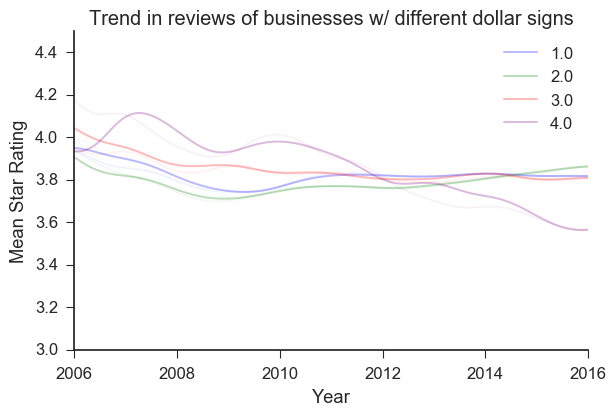

In [38]:
n_samples = 1

# visualize the mean review trend of restaurants within each dollar binns
for price in price_list:
    rr = d['NRB'][d['NRB']['Price']==price]
    for _ in range(n_samples):
        n_r = BootstrapDataframe(rr)
        n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
        plt.plot(np.array(n_gm['x']), np.array(n_gm['y']), c = color_list[price_list.index(price)], alpha= 0.05, label = None)
    
    #plt.plot(n_gm['x'], n_gm['y'], c = color_list[price_list.index(price)], alpha= 1.0, label = price)
    

for price in price_list:
    r = d['NRB'][d['NRB']['Price']==price]
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.plot(gm['x'], gm['y'], c = color_list[price_list.index(price)], label = price, alpha= 0.275)

plt.ylim(3.,4.5)     
plt.title("Trend in reviews of businesses w/ different dollar signs")
plt.ylabel('Mean Star Rating')
plt.xlabel('Year')
plt.legend()
sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/best.png', dpi = 300, fmt = 'png')
    

# Joint distributions

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


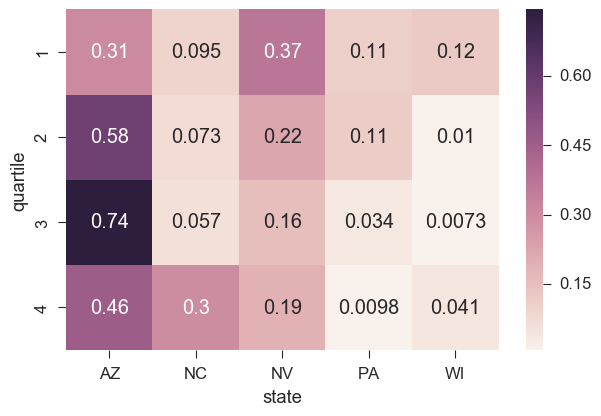

In [39]:
#pd.crosstab quartile
sns.heatmap(pd.crosstab(d['NRB']['quartile'],d['NRB']['state'], normalize = 'index'), annot = True)

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


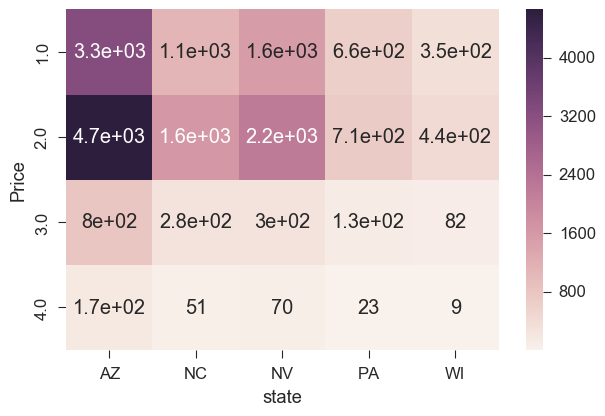

In [40]:
tttttemp = d['NRB'].drop_duplicates('business_id')
sns.heatmap(pd.crosstab(tttttemp['Price'],tttttemp['state'], normalize = False), annot = True)

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


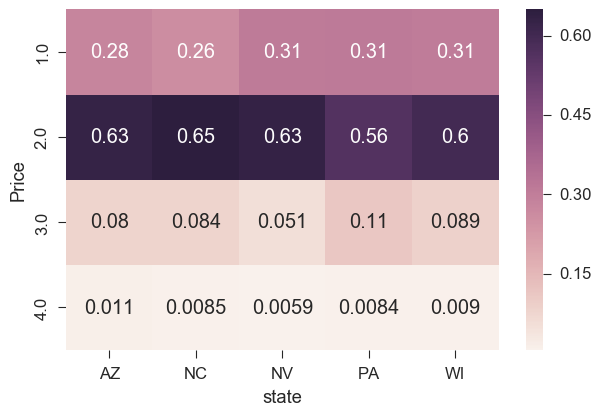

In [41]:
sns.heatmap(pd.crosstab(d['NRB']['Price'],d['NRB']['state'], normalize = 'columns'), annot = True)

## Mean star trends binned by States

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


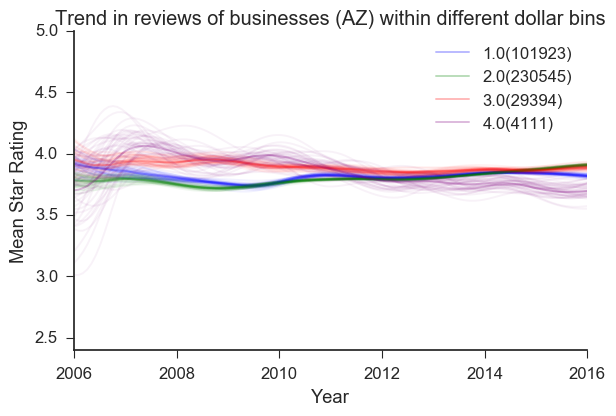

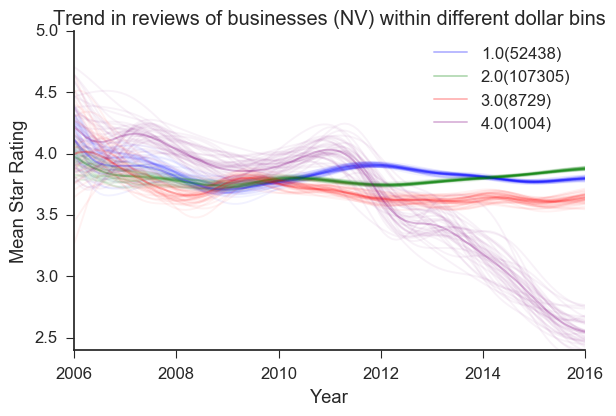

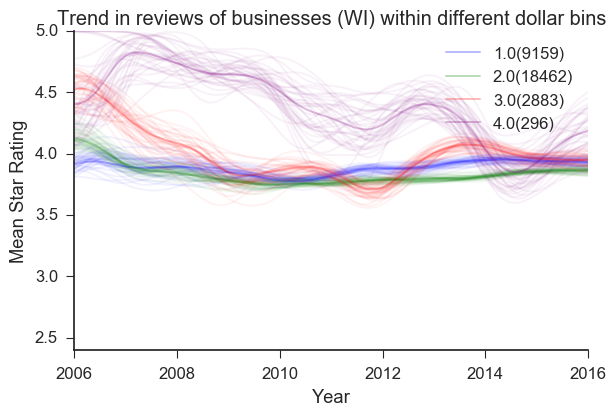

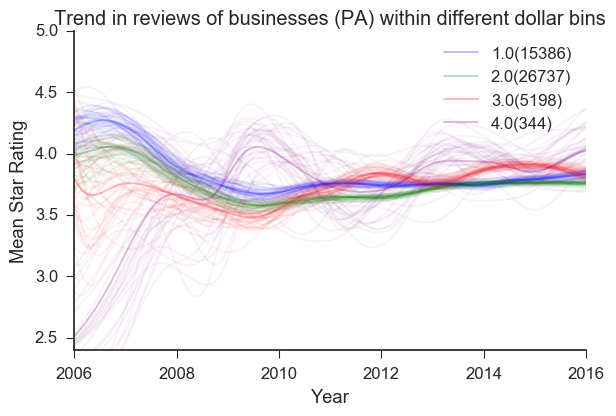

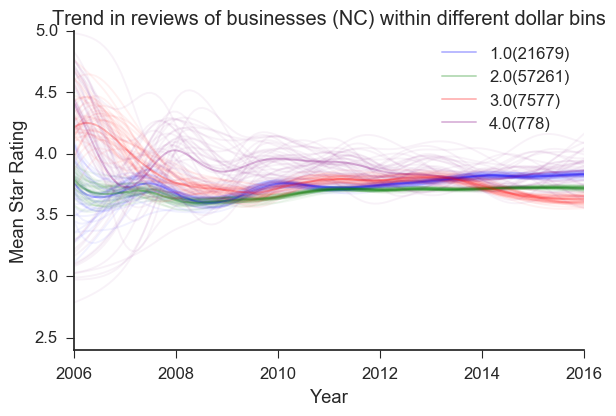

In [14]:
# Graph of businesses binned by state
n_samples = 40

for state in state_list:
    plt.figure()
    r = d['NRB'][d['NRB']['state']==state]
    # visualize the mean review trend of restaurants within each dollar binns
    for price in price_list:
        rr = r[r['Price']==price]
        for _ in range(n_samples):
            n_r = BootstrapDataframe(rr)
            n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
            #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
            plt.plot(np.array(n_gm['x']), np.array(n_gm['y']), c = color_list[price_list.index(price)], alpha= 0.05, label = None)

        #plt.plot(n_gm['x'], n_gm['y'], c = color_list[price_list.index(price)], alpha= 1.0, label = price)


    for price in price_list:
        rr = r[r['Price']==price]
        gm = RollingGaussianMean(rr, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        plt.plot(gm['x'], gm['y'], c = color_list[price_list.index(price)], label = str(price)+"("+str(len(rr))+")", alpha= 0.275)

    plt.ylim(2.4,5.)     
    plt.title("Trend in reviews of businesses ("+ state+ ") within different dollar bins")
    plt.ylabel('Mean Star Rating')
    plt.xlabel('Year')
    plt.legend()
    sns.despine()
    plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/'+state+'.png', dpi = 300, fmt = 'png')
    

## Mean star trends binned by zhvi quartiles

In [58]:
for quart in quartile_list:
    e = d['NRB'][d['NRB']['latest_zhvi']<=d['NRB']['latest_zhvi'].describe()[quart]]
    print (len(e))

180857
396002
541487
713794


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


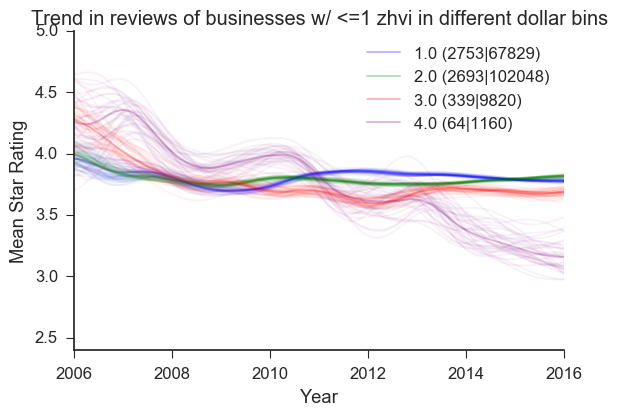

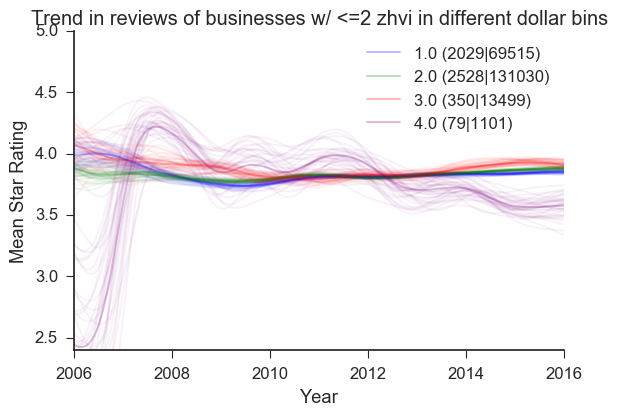

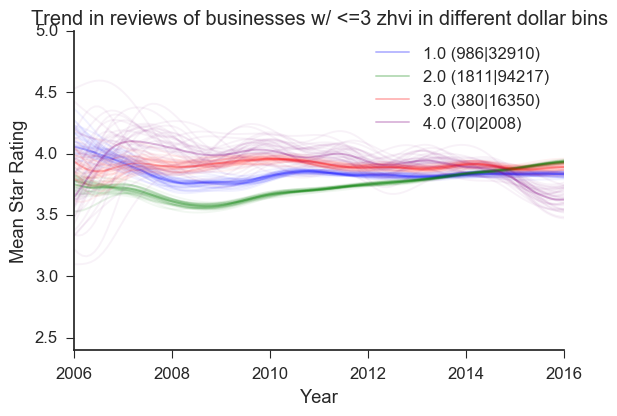

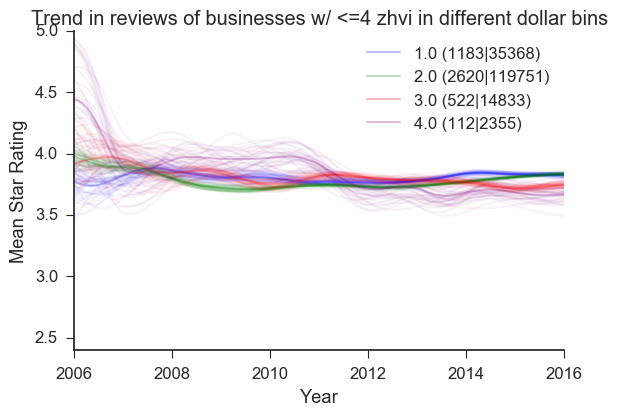

In [59]:
# Graph of businesses binned by state
n_samples = 35

for quart in ottf_list:
    r = d['NRB'][d['NRB']['quartile']==quart]
    plt.figure()
    # visualize the mean review trend of restaurants within each dollar binns
    for price in price_list:
        rr = r[r['Price']==price]
        for _ in range(n_samples):
            n_r = BootstrapDataframe(rr)
            n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
            #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
            plt.plot(np.array(n_gm['x']), np.array(n_gm['y']), c = color_list[price_list.index(price)], alpha= 0.05, label = None)

        #plt.plot(n_gm['x'], n_gm['y'], c = color_list[price_list.index(price)], alpha= 1.0, label = price)


    for price in price_list:
        rr = r[r['Price']==price]
        gm = RollingGaussianMean(rr, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        plt.plot(gm['x'], gm['y'], c = color_list[price_list.index(price)], label = str(price)\
                                 +" ("+str(len(np.unique(rr['business_id'])))+"|"+str(len(rr))+")", alpha= 0.275)

    plt.ylim(2.4,5.)     
    plt.title("Trend in reviews of businesses w/ <="+ str(quart)+ " zhvi in different dollar bins")
    plt.ylabel('Mean Star Rating')
    plt.xlabel('Year')
    plt.legend()
    sns.despine()
    plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/'+str(quart)+'.png', dpi = 300, fmt = 'png')
    



# Regression: By dollor signs (No subgroups)

In [15]:
d['B_F'] = defaultdict(list)
d['B_F']['Price'] = price_list

for price in price_list:
    df = d['NRB'][d['NRB']['Price']==price]
    d['B_F']['mean_star'].append(np.mean(df['stars']))
    lm = sm.OLS(df['stars'], sm.add_constant(df['year'])).fit()
    #mrm.fit(df['year'].reshape(len(df['year']),1), df['stars'].reshape(len(df['stars']),1))
    d['B_F']['slope'].append(lm.params['year'])
    d['B_F']['review_count'].append(len(df))
    d['B_F']['slope_err'].append(lm.bse['year'])
    
d['B_F'] = pd.DataFrame(d['B_F'])

In [16]:
d['B_F']

,Price,mean_star,review_count,slope,slope_err
0,1.0,3.816656,200585,0.004436,0.001474
1,2.0,3.804697,440310,0.018989,0.000995
2,3.0,3.818003,53781,-0.009185,0.002688
3,4.0,3.761518,6533,-0.060095,0.008011


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


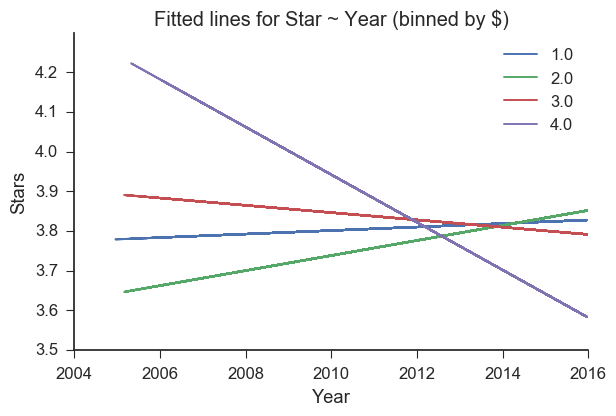

In [26]:
for price in price_list:
    df = d['NRB'][d['NRB']['Price']==price]
    lm = sm.OLS(df['stars'], sm.add_constant(df['year'])).fit()
    plt.plot(df['year'], lm.predict(sm.add_constant(df['year'])), label = price)
plt.xlabel('Year')
plt.ylabel('Stars')
plt.title('Fitted lines for Star ~ Year (binned by $)')
plt.legend()
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/Fitted_line.png', dpi = 300, fmt = 'png')

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


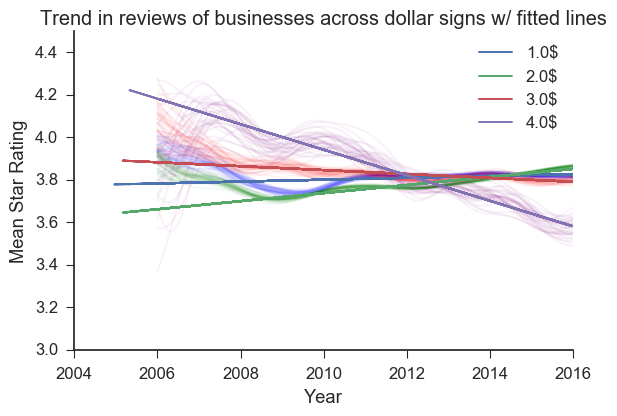

In [57]:
n_samples = 35

# visualize the mean review trend of restaurants within each dollar binns
for price in price_list:
    rr = d['NRB'][d['NRB']['Price']==price]
    for _ in range(n_samples):
        n_r = BootstrapDataframe(rr)
        n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
        plt.plot(np.array(n_gm['x']), np.array(n_gm['y']), c = color_list[price_list.index(price)], alpha= 0.05, label = None)
    
    #plt.plot(n_gm['x'], n_gm['y'], c = color_list[price_list.index(price)], alpha= 1.0, label = price)
    

for price in price_list:
    df = d['NRB'][d['NRB']['Price']==price]
    lm = sm.OLS(df['stars'], sm.add_constant(df['year'])).fit()
    plt.plot(df['year'], lm.predict(sm.add_constant(df['year'])), label = str(price)+'$')


plt.ylim(3.,4.5)     
plt.title("Trend in reviews of businesses across dollar signs w/ fitted lines")
plt.ylabel('Mean Star Rating')
plt.xlabel('Year')
plt.legend()
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/On_TOP_OF.png', dpi = 300, fmt = 'png')


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


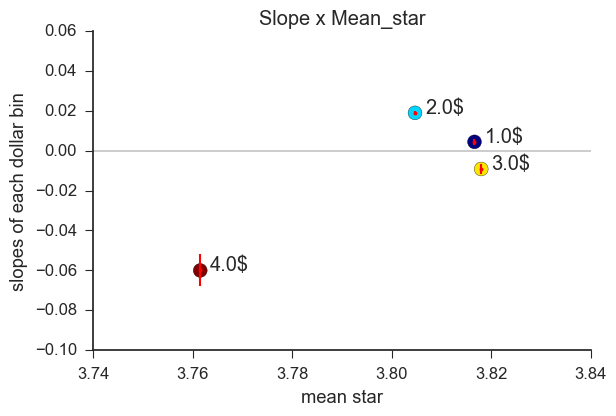

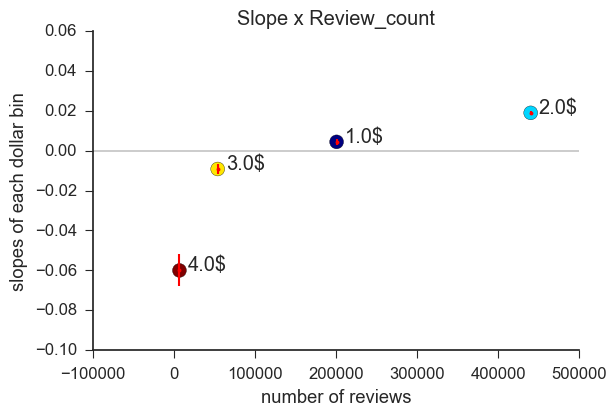

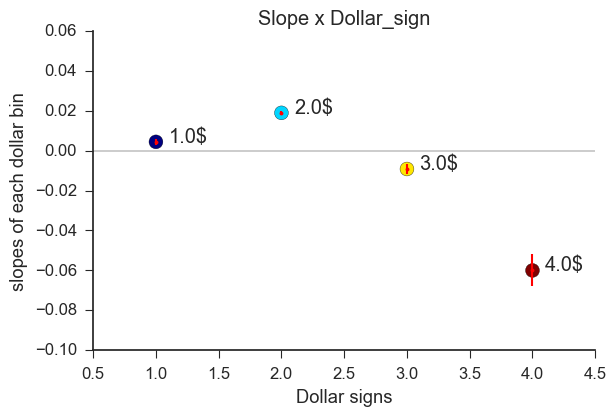

In [32]:
plt.scatter(d['B_F']['mean_star'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.errorbar(d['B_F']['mean_star'], d['B_F']['slope'], yerr = d['B_F']['slope_err'],fmt = '.',color = 'red', lw = 1.5)
plt.xlabel('mean star')
plt.ylabel('slopes of each dollar bin')
plt.title('Slope x Mean_star')
plt.axhline(y=0., color='gray', alpha = .4)
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['mean_star']+0.002,temp['slope']+0.00002))

sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_mean_stars.png', dpi = 300, fmt = 'png')

plt.figure()
plt.scatter(d['B_F']['review_count'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.errorbar(d['B_F']['review_count'], d['B_F']['slope'], yerr = d['B_F']['slope_err'],fmt = '.',color = 'red', lw = 1.5)
plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('number of reviews')
plt.ylabel('slopes of each dollar bin')
plt.title('Slope x Review_count')
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['review_count']+10000,temp['slope']+0.00002))
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_review_count.png', dpi = 300, fmt = 'png')


plt.figure()
plt.scatter(d['B_F']['Price'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.errorbar(d['B_F']['Price'], d['B_F']['slope'], yerr = d['B_F']['slope_err'],fmt = '.',color = 'red', lw = 1.5)
plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('Dollar signs')
plt.ylabel('slopes of each dollar bin')
plt.title('Slope x Dollar_sign')
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['Price']+.1,temp['slope']+0.00002))
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_dollar_sign.png', dpi = 300, fmt = 'png')

# Regression: Review Slope ~ Dollor Signs (grouped by State)

In [9]:
state_wls = pd.DataFrame(np.unique(d['N']['state']))
state_wls.columns = ['state']

In [10]:
for price in price_list:
    d['NRB'][price] = d['NRB']['Price'].astype('str').apply(InCategory, args = (str(price),))
    d['CRB'] = d['NRB'][d['NRB'][price] == 1]
    state_wls = pd.merge(SelectMultipleWLS(d['CRB'], 'stars', 'year', np.unique(d['CRB']['state']), 'state', str(price)), state_wls,\
                   on = 'state', how = 'outer')

state_wls = state_wls.drop([col for col in state_wls.columns if '_pval' in col], axis = 1)
temp = state_wls

In [11]:
temp

,4.0_mean,4.0_p_value,4.0_slope,4.0_slope_err,state,4.0_c_hyp,3.0_mean,3.0_p_value,3.0_slope,3.0_slope_err,...,2.0_mean,2.0_p_value,2.0_slope,2.0_slope_err,2.0_c_hyp,1.0_mean,1.0_p_value,1.0_slope,1.0_slope_err,1.0_c_hyp
0,3.789832,2.323412e-04,-0.039104,0.010614,AZ,True,3.877118,0.057059,-0.006709,0.003526,...,3.832319,1.284493e-69,0.023490,0.001331,True,3.822454,2.053832e-04,0.007502,0.002021,True
1,3.856041,5.438244e-01,-0.015048,0.024779,NC,False,3.724825,0.001077,-0.024570,0.007512,...,3.709558,8.886414e-04,0.009276,0.002791,True,3.789105,2.872775e-07,0.022950,0.004471,True
2,3.402390,7.107556e-28,-0.193688,0.017168,NV,True,3.650590,0.012777,-0.017892,0.007184,...,3.813038,4.242433e-17,0.019599,0.002331,True,3.814371,2.422039e-05,-0.014692,0.003480,True
3,3.880814,3.308514e-01,0.033890,0.034803,PA,False,3.822047,0.000071,0.037740,0.009492,...,3.725848,1.142546e-06,0.018796,0.003862,True,3.774015,1.962227e-01,0.006298,0.004873,False
4,4.199324,4.719243e-03,-0.083569,0.029350,WI,True,3.959764,0.800604,0.002623,0.010386,...,3.820550,6.102257e-02,0.007257,0.003873,True,3.902064,2.114328e-03,0.015468,0.005031,True


In [12]:
state_wls = defaultdict(list)

for state in state_list:
    state_wls['state'] += [state]*4
    for_n = d['NRB'][d['NRB']['state']==state]
    for price in price_list:
        state_wls['price'].append(price) 
        t_temp = temp[temp['state']==state]
        state_wls['slope'].append(float(t_temp[str(price)+'_slope']))
        state_wls['slope_err'].append(float(t_temp[str(price)+'_slope_err']))
        state_wls['mean_star'].append(float(t_temp[str(price)+'_mean']))
        state_wls['c_hyp'].append(t_temp[str(price)+'_c_hyp'])
        state_wls['review_count'].append(len(for_n[for_n['Price']==price]))
        
state_wls = pd.DataFrame(state_wls)

In [14]:
state_wls.head(8)

,c_hyp,mean_star,price,review_count,slope,slope_err,state
0,"0 True Name: 1.0_c_hyp, dtype: bool",3.822454,1.0,101923,0.007502,0.002021,AZ
1,"0 True Name: 2.0_c_hyp, dtype: bool",3.832319,2.0,230545,0.023490,0.001331,AZ
2,"0 True Name: 3.0_c_hyp, dtype: bool",3.877118,3.0,29394,-0.006709,0.003526,AZ
3,"0 True Name: 4.0_c_hyp, dtype: bool",3.789832,4.0,4111,-0.039104,0.010614,AZ
4,"2 True Name: 1.0_c_hyp, dtype: bool",3.814371,1.0,52438,-0.014692,0.003480,NV
5,"2 True Name: 2.0_c_hyp, dtype: bool",3.813038,2.0,107305,0.019599,0.002331,NV
6,"2 True Name: 3.0_c_hyp, dtype: bool",3.650590,3.0,8729,-0.017892,0.007184,NV
7,"2 True Name: 4.0_c_hyp, dtype: bool",3.402390,4.0,1004,-0.193688,0.017168,NV


In [38]:
df = state_wls

mrm = sm.WLS(df['slope'],sm.add_constant(df['mean_star']), weights = np.sqrt(df['review_count'])).fit()
n_mrm = sm.WLS(df['slope'],sm.add_constant(df['review_count']), weights = np.sqrt(df['review_count'])).fit()
#p_mrm = sm.WLS(df['slope'],sm.add_constant(df['price']), weights = np.sqrt(df['review_count'])).fit()

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


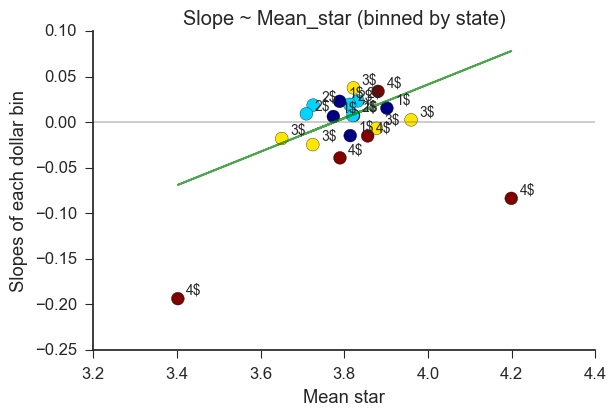

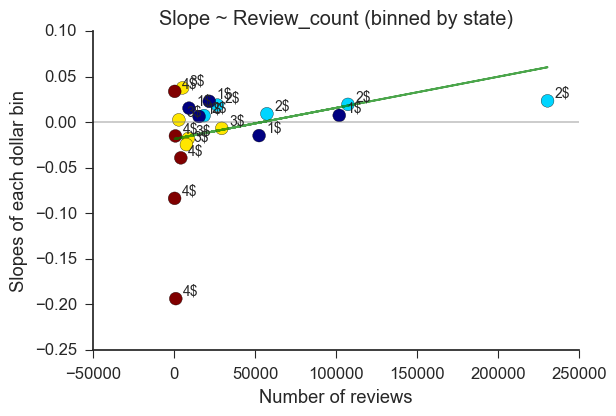

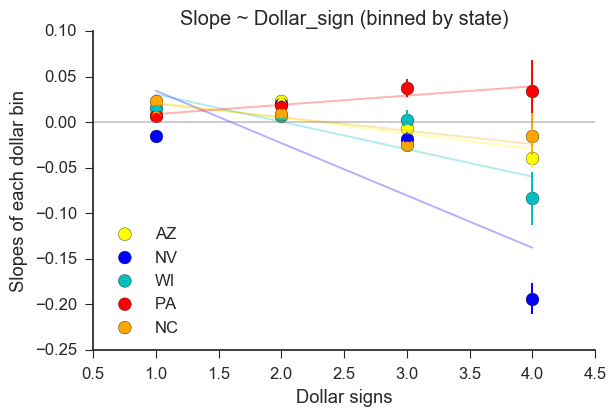

In [50]:
plt.figure()
plt.scatter(np.array(state_wls['mean_star']),np.array(state_wls['slope']), c = state_wls['price'], cmap = 'jet',s=85)
plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('Mean star')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Mean_star (binned by state)')
plt.plot(state_wls['mean_star'], mrm.predict(sm.add_constant(state_wls['mean_star'])), c = 'g',alpha = .7)
for price in price_list:
    temp = state_wls[state_wls['price']==price]
    for state in state_list:
        t_temp = temp[temp['state']==state]
        plt.annotate(str(int(price))+"$", xy=(t_temp['mean_star']+0.02,t_temp['slope']+0.005),size = 10)
plt.legend()
sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_mean_stars(by State).png', dpi = 300, fmt = 'png')

plt.figure()
plt.scatter(np.array(state_wls['review_count']),np.array(state_wls['slope']), c = state_wls['price'], cmap = 'jet',s=85)
plt.axhline(y=0., color='gray', alpha = .4)
plt.plot(state_wls['review_count'], n_mrm.predict(sm.add_constant(state_wls['review_count'])), c = 'g',alpha = .7)
plt.xlabel('Number of reviews')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Review_count (binned by state)')
plt.legend()
for price in price_list:
    temp = state_wls[state_wls['price']==price]
    for state in state_list:
        t_temp = temp[temp['state']==state]
        plt.annotate(str(int(price))+"$", xy=(t_temp['review_count']+4500,t_temp['slope']+0.004),size = 10)

sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_review_count(by State).png', dpi = 300, fmt = 'png')


plt.figure()
color_dict = {'WI':'c','PA':'red', 'NC':'orange', 'AZ':'yellow','NV':'blue'}
for state in state_list:
    ttt = state_wls[state_wls['state']==state]
    plt.scatter(ttt['price'],np.array(ttt['slope']), \
                c = color_dict[state],s=85,label = state)
    plt.errorbar(ttt['price'], np.array(ttt['slope']),\
                 yerr = ttt['slope_err'],fmt = 'o',c = color_dict[state])
    p_mrm = sm.WLS(ttt['slope'],sm.add_constant(ttt['price'])).fit()
    plt.plot(ttt['price'], p_mrm.predict(sm.add_constant(ttt['price'])), c = color_dict[state],alpha = .3)

plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('Dollar signs')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Dollar_sign (binned by state)')
plt.legend(loc = 3)
# for price in price_list:
#     temp = state_wls[state_wls['price']==price]
#     for state in state_list:
#         t_temp = temp[temp['state']==state]
#         plt.annotate(str(int(price))+"$"+state, xy=(t_temp['price']+.1,t_temp['slope']+0.004),size = 8)

sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_dollar_sign(by State).png', dpi = 300, fmt = 'png')




# Regression: Review Slope ~ Dollor Signs (grouped by zhvi quartile)

In [42]:
ottf_list = [1,2,3,4]
quartile_wls = pd.DataFrame({'quartile':ottf_list})
# add a column to d['NRB'] to indicate the quartile
d['NRB']['quartile']= pd.qcut(d['NRB']['latest_zhvi'], q=4, labels=False)+1

In [43]:
len(np.unique(d['NRB']['z_hood']))

257

In [44]:
for q in ottf_list:
    t = d['NRB'][d['NRB']['quartile']==q]
    print(t['latest_zhvi'].describe())

count    180857.000000
mean     157331.287702
std       31303.517043
min       46800.000000
25%      145100.000000
50%      150600.000000
75%      173400.000000
max      205400.000000
Name: latest_zhvi, dtype: float64
count    215145.000000
mean     240166.742894
std       23384.178444
min      206500.000000
25%      212300.000000
50%      238600.000000
75%      268000.000000
max      268000.000000
Name: latest_zhvi, dtype: float64
count    145485.000000
mean     282838.558614
std        5260.734542
min      268300.000000
25%      283300.000000
50%      283300.000000
75%      286500.000000
max      290600.000000
Name: latest_zhvi, dtype: float64
count    172307.000000
mean     411924.635679
std      113133.820817
min      290800.000000
25%      313100.000000
50%      374400.000000
75%      504500.000000
max      998400.000000
Name: latest_zhvi, dtype: float64


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


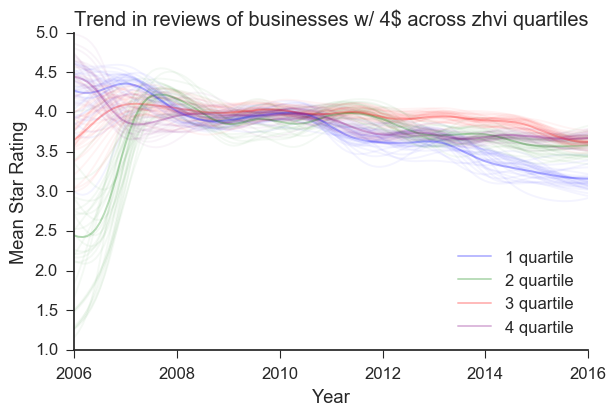

In [51]:
n_samples = 30

# visualize the mean review trend of restaurants within each dollar binns
for quart in ottf_list:
    rr = d['NRB'][(d['NRB']['quartile']==quart) & (d['NRB']['Price']==4.)]
    for _ in range(n_samples):
        n_r = BootstrapDataframe(rr)
        n_gm = RollingGaussianMean(n_r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
        #plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
        plt.plot(np.array(n_gm['x']), np.array(n_gm['y']), c = color_list[ottf_list.index(quart)], alpha= 0.045, label = None)
    

for quart in ottf_list:
    r = d['NRB'][(d['NRB']['quartile']==quart) & (d['NRB']['Price']==4.)]
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.plot(gm['x'], gm['y'], c = color_list[ottf_list.index(quart)], label = str(quart)+' quartile', alpha= 0.275)

    
plt.title("Trend in reviews of businesses w/ 4$ across zhvi quartiles")
plt.ylabel('Mean Star Rating')
plt.xlabel('Year')
plt.legend(loc = 4)
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/4$Review_trend(binned_by_zhvi).png', dpi = 300, fmt = 'png')
    

In [29]:
for price in price_list:
    d['CRB'] = d['NRB'][d['NRB'][price] == 1]
    quartile_wls = pd.merge(SelectMultipleWLS(d['CRB'], 'stars', 'year', np.unique(d['CRB']['quartile']), 'quartile', str(price)), quartile_wls,\
                   on = 'quartile', how = 'outer')

quartile_wls = quartile_wls.drop([col for col in quartile_wls.columns if '_pval' in col], axis = 1)
temp = quartile_wls

In [30]:
temp

,4.0_mean,4.0_p_value,4.0_slope,4.0_slope_err,quartile,4.0_c_hyp,3.0_mean,3.0_p_value,3.0_slope,3.0_slope_err,...,2.0_mean,2.0_p_value,2.0_slope,2.0_slope_err,2.0_c_hyp,1.0_mean,1.0_p_value,1.0_slope,1.0_slope_err,1.0_c_hyp
0,3.588287,5.916010e-15,-0.129538,0.016367,1,True,3.668014,0.036879,-0.013105,0.006278,...,3.781426,1.353290e-03,0.006614,0.002064,True,3.812435,0.216871,-0.003146,0.002547,False
1,3.747628,6.982282e-03,-0.060930,0.022541,2,True,3.885291,0.223145,0.006515,0.005348,...,3.845267,2.581966e-11,0.012272,0.001840,True,3.817429,0.000019,0.010874,0.002540,True
2,3.883964,2.044605e-03,-0.045536,0.014747,3,True,3.901763,0.153769,-0.006744,0.004728,...,3.813346,2.841001e-103,0.045210,0.002093,True,3.828116,0.601495,0.001932,0.003699,False
3,3.746160,2.237804e-03,-0.044232,0.014454,4,True,3.767346,0.002519,-0.016536,0.005473,...,3.776298,3.584505e-17,0.016823,0.001996,True,3.812667,0.006387,0.009809,0.003597,True


In [31]:
quartile_wls = defaultdict(list)

for quart in ottf_list:
    quartile_wls['quartile'] += [quart]*4
    for_n = d['NRB'][d['NRB']['quartile']==quart]
    for price in price_list:
        quartile_wls['price'].append(price) 
        t_temp = temp[temp['quartile']==quart]
        quartile_wls['slope'].append(float(t_temp[str(price)+'_slope']))
        quartile_wls['slope_err'].append(float(t_temp[str(price)+'_slope_err']))
        quartile_wls['mean_star'].append(float(t_temp[str(price)+'_mean']))
        quartile_wls['c_hyp'].append(t_temp[str(price)+'_c_hyp'])
        quartile_wls['review_count'].append(len(for_n[for_n['Price']==price]))
        
quartile_wls = pd.DataFrame(quartile_wls)

In [44]:
quartile_wls

,c_hyp,mean_star,price,quartile,review_count,slope,slope_err
0,"0 False Name: 1.0_c_hyp, dtype: bool",3.812435,1.0,1,67662,-0.003146,0.002547
1,"0 True Name: 2.0_c_hyp, dtype: bool",3.781426,2.0,1,104834,0.006614,0.002064
2,"0 True Name: 3.0_c_hyp, dtype: bool",3.668014,3.0,1,9898,-0.013105,0.006278
3,"0 True Name: 4.0_c_hyp, dtype: bool",3.588287,4.0,1,1127,-0.129538,0.016367
4,"1 True Name: 1.0_c_hyp, dtype: bool",3.817429,1.0,2,65098,0.010874,0.002540
5,"1 True Name: 2.0_c_hyp, dtype: bool",3.845267,2.0,2,123012,0.012272,0.001840
6,"1 False Name: 3.0_c_hyp, dtype: bool",3.885291,3.0,2,12815,0.006515,0.005348
7,"1 True Name: 4.0_c_hyp, dtype: bool",3.747628,4.0,2,1054,-0.060930,0.022541
8,"2 False Name: 1.0_c_hyp, dtype: bool",3.828116,1.0,3,32743,0.001932,0.003699
9,"2 True Name: 2.0_c_hyp, dtype: bool",3.813346,2.0,3,94003,0.045210,0.002093


In [33]:
df = quartile_wls

mrm = sm.WLS(df['slope'],sm.add_constant(df['mean_star']), weights = np.sqrt(df['review_count'])).fit()
n_mrm = sm.WLS(df['slope'],sm.add_constant(df['review_count']), weights = np.sqrt(df['review_count'])).fit()
#p_mrm = sm.WLS(df['slope'],sm.add_constant(df['price']), weights = np.sqrt(df['review_count'])).fit()

In [103]:
tt

,c_hyp,mean_star,price,quartile,review_count,slope,slope_err
12,"3 True Name: 1.0_c_hyp, dtype: bool",3.812667,1.0,4,35082,0.009809,0.003597
13,"3 True Name: 2.0_c_hyp, dtype: bool",3.776298,2.0,4,118461,0.016823,0.001996
14,"3 True Name: 3.0_c_hyp, dtype: bool",3.767346,3.0,4,14730,-0.016536,0.005473
15,"3 True Name: 4.0_c_hyp, dtype: bool",3.746160,4.0,4,2344,-0.044232,0.014454


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


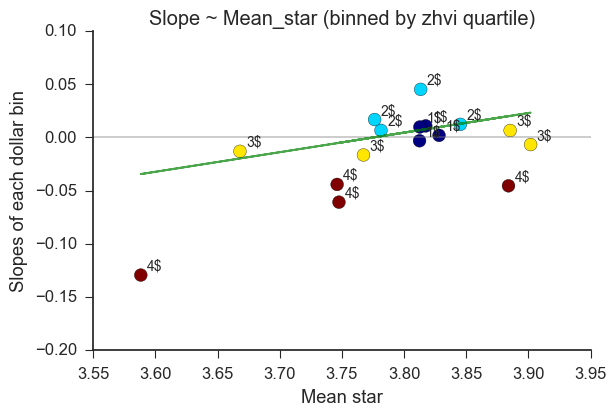

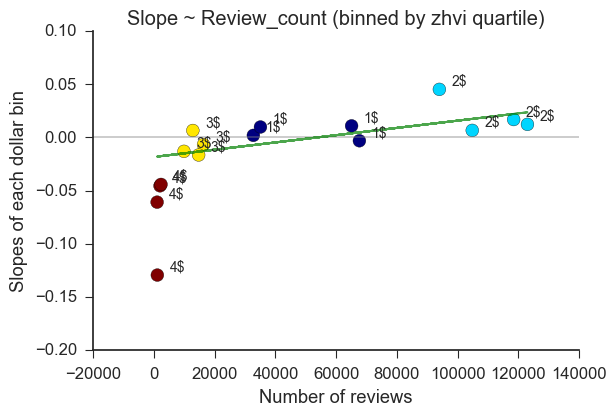

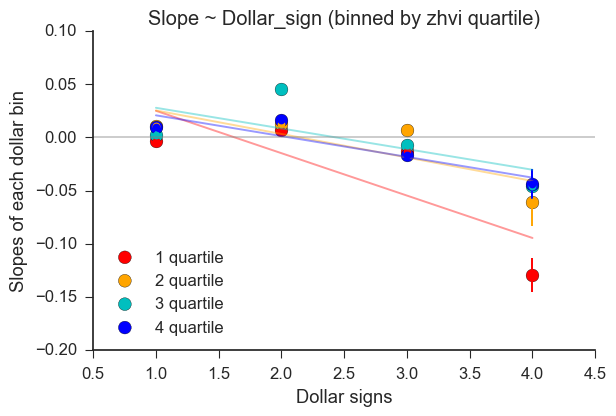

In [56]:
plt.figure()
plt.scatter(np.array(quartile_wls['mean_star']),np.array(quartile_wls['slope']), c = quartile_wls['price'], cmap = 'jet',s=85)
plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('Mean star')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Mean_star (binned by zhvi quartile)')
plt.plot(quartile_wls['mean_star'], mrm.predict(sm.add_constant(quartile_wls['mean_star'])), c = 'g',alpha = .7)
for price in price_list:
    temp = quartile_wls[quartile_wls['price']==price]
    for quart in ottf_list:
        t_temp = temp[temp['quartile']==quart]
        plt.annotate(str(int(price))+"$", xy=(t_temp['mean_star']+0.005,t_temp['slope']+0.005),size = 10)
plt.legend()
sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_mean_stars(by quartile).png', dpi = 300, fmt = 'png')

plt.figure()
plt.scatter(np.array(quartile_wls['review_count']),np.array(quartile_wls['slope']), c = quartile_wls['price'], cmap = 'jet',s=85)
plt.axhline(y=0., color='gray', alpha = .4)
plt.plot(quartile_wls['review_count'], n_mrm.predict(sm.add_constant(quartile_wls['review_count'])), c = 'g',alpha = .7)
plt.xlabel('Number of reviews')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Review_count (binned by zhvi quartile)')
plt.legend()
for price in price_list:
    temp = quartile_wls[quartile_wls['price']==price]
    for quart in ottf_list:
        t_temp = temp[temp['quartile']==quart]
        plt.annotate(str(int(price))+"$", xy=(t_temp['review_count']+4000,t_temp['slope']+0.004),size = 10)

sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_review_count(by quartile).png', dpi = 300, fmt = 'png')


plt.figure()
color_dict = {1:'r', 2:'orange', 3:'c', 4:'b'}
for quart in ottf_list:
    tt = quartile_wls[quartile_wls['quartile']==quart]
    plt.scatter(tt['price'],np.array(tt['slope']), \
                c = color_dict[quart],s=85,label = str(quart)+" quartile")
    plt.errorbar(tt['price'], np.array(tt['slope']),\
                 yerr = tt['slope_err'],fmt = 'o',c = color_dict[quart])
    p_mrm = sm.WLS(tt['slope'],sm.add_constant(tt['price'])).fit()
    plt.plot(tt['price'], p_mrm.predict(sm.add_constant(tt['price'])), c = color_dict[quart],alpha = .4)
plt.axhline(y=0., color='gray', alpha = .4)
plt.xlabel('Dollar signs')
plt.ylabel('Slopes of each dollar bin')
plt.title('Slope ~ Dollar_sign (binned by zhvi quartile)')
plt.legend(loc = 3)
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/jac_project_graphs/slope_dollar_sign(by quartile).png', dpi = 300, fmt = 'png')




# Analyzing the distribution w/ Business grouped by neighborhood (Null Result)

In [73]:
nzy.head()

,latest_sqft,latest_zhvi,mean_price,mean_price_err,mean_stars,mean_stars_err,n,z_hood,loop_i,state,...,2.0_mean,2.0_p_value,2.0_slope,2.0_slope_err,2.0_c_hyp,1.0_mean,1.0_p_value,1.0_slope,1.0_slope_err,1.0_c_hyp
0,133.0,212300.0,1.578729,0.022885,3.674437,0.028320,1244,111818,434.0,AZ,...,3.682440,0.036340,0.015160,0.007242,False,3.765981,0.183646,0.009191,0.006912,False
1,95.0,185400.0,1.494253,0.056013,3.232558,0.089071,129,112261,290.0,AZ,...,2.983577,0.005020,-0.110429,0.039199,True,3.448718,0.829815,0.006141,0.028562,False
2,96.0,134900.0,1.472028,0.037214,3.341801,0.050409,433,112345,340.0,AZ,...,3.381643,0.000002,-0.099661,0.021090,True,3.630384,0.319805,-0.018775,0.018868,False
3,165.0,286500.0,1.734818,0.021098,3.807175,0.022346,1784,112547,420.0,AZ,...,3.785621,0.000004,0.024109,0.005226,True,3.821198,0.236340,-0.008789,0.007422,False
4,222.0,425800.0,2.303030,0.072616,3.654321,0.056116,162,180250,3898.0,NC,...,3.763763,0.150177,0.015846,0.011011,False,3.539683,0.154901,-0.061346,0.043024,False


In [64]:
yelp_wls = d['N'][['z_hood']]

In [65]:
for price in price_list:
    d['RB'][price] = d['RB']['Price'].astype('str').apply(InCategory, args = (price,))
    d['CRB'] = d['RB'][d['RB'][price] == 1]
    yelp_wls = pd.merge(SelectMultipleWLS(d['CRB'], 'stars', 'year', np.unique(d['CRB']['z_hood']), 'z_hood', price), yelp_wls,\
                   on = 'z_hood', how = 'outer')

yelp_wls = yelp_wls.drop([col for col in yelp_wls.columns if '_pval' in col], axis = 1)
nzy = pd.merge(d['N'], yelp_wls, on = 'z_hood').drop(['Unnamed: 0'], axis = 1).drop_duplicates()

number of data poitns:  192


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


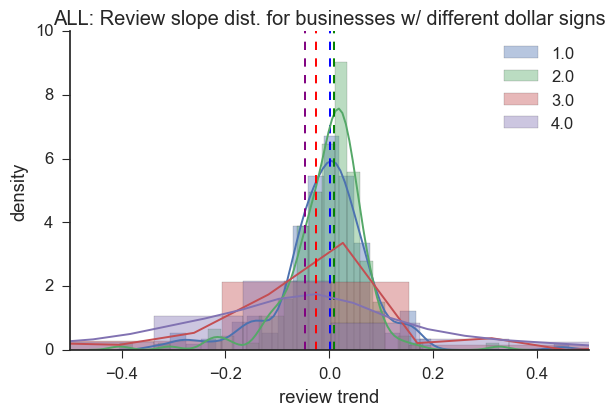

In [45]:
print ("number of data poitns: ", len(nzy))
for price in price_list:
    sns.distplot(nzy[price+'_slope'].dropna(), label = price)
    plt.axvline(np.median(nzy[price+'_slope'].dropna()), linestyle = 'dashed', c = color_list[price_list.index(price)])

plt.xlim(-.5,.5)
plt.title('ALL: Review slope dist. for businesses w/ different dollar signs')
plt.xlabel('review trend')
plt.ylabel('density')
plt.legend()
sns.despine()
plt.savefig('/Users/zihaoxu/Desktop/ALL:Gentrification dist.png', dpi = 300, fmt = 'png')



## Fitting a Linear Model

In [71]:
# Creating a new data frame
d['DS'] = defaultdict(list)

for neighborhood in np.unique(nzy['z_hood']):
    d['DS']['z_hood'] += 4 * [neighborhood]
    temp = d['RB'][d['RB']['z_hood']==neighborhood]
    for price in price_list:
        d['DS']['price'].append(float(price))
        d['DS']['slope'].append(float(nzy[nzy['z_hood']==neighborhood][str(price)+'_slope']))
        n_temp = temp[temp['Price']==float(price)]
        d['DS']['n'].append(len(np.unique(n_temp['business_id'])))
        d['DS']['n_review'].append(len(temp[temp['Price']==float(price)]))
        d['DS']['c_hyp'].append(float(nzy[nzy['z_hood']==neighborhood][str(price)+'_c_hyp']))
        d['DS']['mean_star'].append(np.mean(temp[temp['Price']==float(price)]['stars']))

d['DS'] = pd.DataFrame(d['DS']).dropna()

In [144]:
d['DS'].head()

,c_hyp,mean_star,n,n_review,price,slope,z_hood
0,0.0,3.765981,347,9918,1.0,0.009191,111818
1,0.0,3.682440,342,11031,2.0,0.015160,111818
2,0.0,3.182432,28,296,3.0,-0.013807,111818
3,0.0,3.089552,7,67,4.0,-0.179174,111818
4,0.0,3.448718,45,858,1.0,0.006141,112261


In [165]:
df = d['DS']

# Running regression
mrm = sm.WLS(df['slope'],sm.add_constant(df['mean_star']), weights = np.sqrt(df['n_review'])).fit()
n_mrm = sm.WLS(df['slope'],sm.add_constant(df['n_review']), weights = np.sqrt(df['n_review'])).fit()
p_mrm = sm.WLS(df['slope'],sm.add_constant(df['price']), weights = np.sqrt(df['n_review'])).fit()



#p_mrm.fit(.reshape(len(df['mean_star']),1), .reshape(len(df['slope']),1))
#n_mrm.fit(df['n_review'].reshape(len(df['n_review']),1), df['slope'].reshape(len(df['slope']),1))
#mrm.fit(df['price'].reshape(len(df['price']),1), df['slope'].reshape(len(df['slope']),1))


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


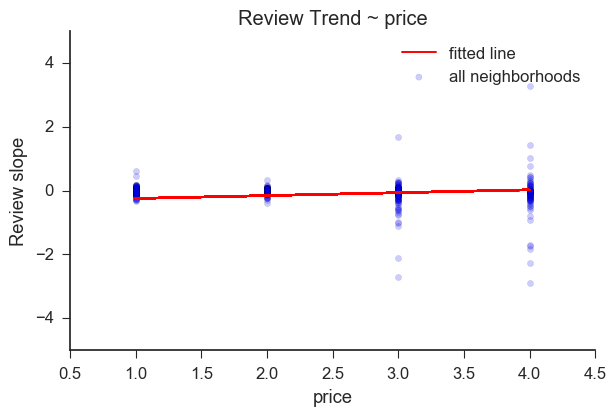

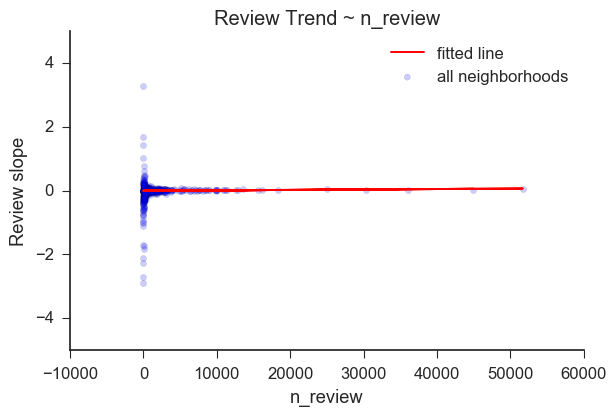

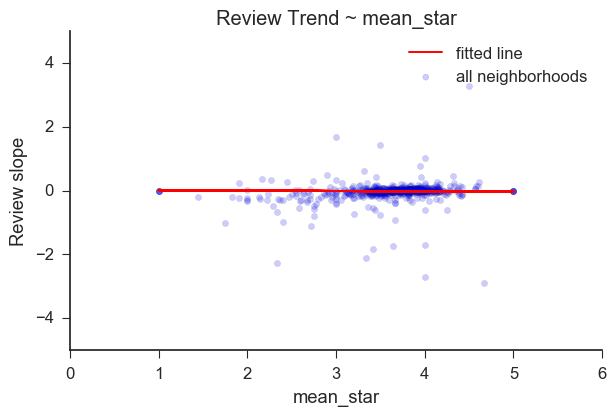

In [166]:
variables = ['price', 'n_review', 'mean_star']
var_models = [mrm, n_mrm, p_mrm]

for i in range(len(variables)):
    plt.figure()
    plt.scatter(df[variables[i]], df['slope'], c = 'b', label = 'all neighborhoods', alpha = 0.2)
    plt.plot(df[variables[i]], var_models[i].predict(sm.add_constant(df[variables[i]])), c = 'r', label = 'fitted line') #.reshape(len(df[variables[i]]),1)
    plt.legend()
    plt.title('Review Trend ~ '+variables[i])
    plt.xlabel(variables[i])
    plt.ylabel('Review slope')
    plt.ylim(-5,5)
    sns.despine()
    #plt.savefig('/Users/zihaoxu/Desktop/Review Trend~'+variables[i]+'.png', dpi = 300, fmt = 'png')


In [98]:
len(df)

629

In [132]:
c_response = df[['slope']]

c_features = df[['mean_star']]
#c_features = df[['n', 'price']]
c_null = pd.DataFrame(np.ones(len(c_features)))
#c_null = df[['mean_star', 'n']]
#c_response = df[['slope']]


In [133]:
std_errors = defaultdict(list)
#models = {'LASSO': linear_model.Lasso(alpha = 0.000001), 'RF':RandomForestRegressor(), 'Linear': linear_model.LinearRegression()}
sim_num = 1000

#for model in models
for i in range(sim_num):
    
    X_train, X_test, y_train, y_test = train_test_split(c_features, c_response, test_size = 0.50)
    nX_train, nX_test, ny_train, ny_test = train_test_split(c_null, c_response, test_size = 0.50)

    #choose which kind of model to use
    
    #mrm = RandomForestRegressor() #mean rent model
    #n_mrm = RandomForestRegressor() #null mean rent model

    mrm = linear_model.LinearRegression()
    n_mrm = linear_model.LinearRegression()
    
    #mrm = svm.SVC()
    #n_mrm = svm.SVC()

    #train the model
    train_and_evaluate(mrm, X_train, np.ravel(y_train), verbose = False) #train the model on the data
    train_and_evaluate(n_mrm, nX_train, np.ravel(ny_train), verbose = False) #train the model on the data
    
    #append the standard error to the list
    std_errors['dollar_sign'].append(np.std(np.array(mrm.predict(X_test)) - y_test['slope']))
    std_errors['null'].append(np.std(np.array(n_mrm.predict(nX_test)) - ny_test['slope']))


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


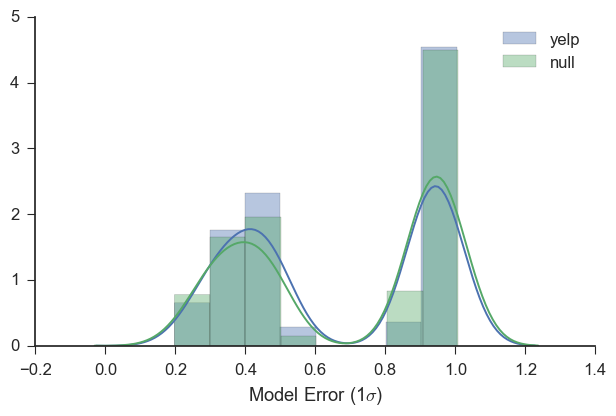

In [134]:
#plot the error distributions
sns.distplot(std_errors['dollar_sign'], label = 'yelp') #with the yelp features
sns.distplot(std_errors['null'], label = 'null') #just the dummies
plt.xlabel('Model Error (1$\sigma$)')
plt.legend()
sns.despine()

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


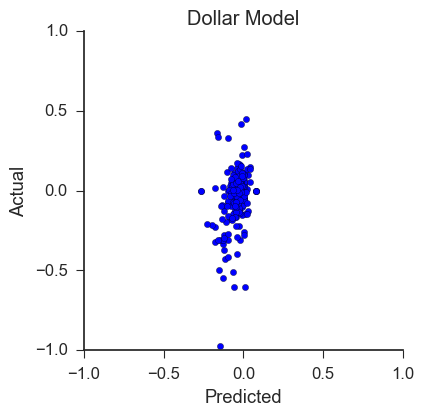

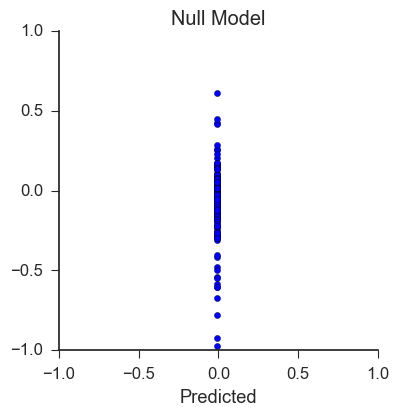

In [135]:

plt.figure()
plt.scatter(mrm.predict(X_test), y_test)
plt.title('Dollar Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.plot([.5,4.5], [.5,4.5], lw = 1, c = 'grey')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gca().set_aspect('equal')
sns.despine()

plt.figure()
plt.scatter(n_mrm.predict(nX_test), ny_test)
plt.title('Null Model')
plt.xlabel('Predicted')
#plt.plot([.5,4.5], [.5,4.5], lw = 1, c = 'grey')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gca().set_aspect('equal')
sns.despine()

# Analyzing the distribution of individual businesses

In [13]:
print('Number of Total reviewsL ', len(d['NRB']))
print('Number of individual businesses: ', len(np.unique(d['NRB']['business_id'])))

Number of individual businesses:  17991
Number of Total reviewsL  701209


In [20]:
buz_wls = pd.DataFrame({'business_id':np.unique(d['NRB']['business_id'])})

In [23]:
buz_wls = pd.merge(SelectMultipleWLS(d['NRB'], 'stars', 'year', np.unique(d['NRB']['business_id']), 'business_id', ''), buz_wls,\
                   on = 'business_id', how = 'outer')

In [45]:
buz_wls.drop('_c_pvals', axis = 1, inplace = True)
buz_wls.columns = ['mean','p_value','slope','slope_err','business_id','c_hyp']

In [54]:
buz_wls = pd.merge(d['B'], buz_wls, on = 'business_id').drop('Unnamed: 0', axis = 1)

In [57]:
buz_wls.to_csv('/Users/zihaoxu/jac_project/buz_wls.csv')

In [58]:
buz_wls.head()

,business_id,mean_stars,categories,name,review_count,open,stars,latitude,longitude,z_hood,Price,mean,p_value,slope,slope_err,c_hyp
0,--4Pe8BZ6gj57VFL5mUE8g,2.857143,"['Shopping', 'Office Equipment']",Office Max,8,True,3.0,33.678615,-111.974607,267919,3.0,2.857143,0.275415,0.410407,0.335250,False
1,--5jkZ3-nUPZxUvtcbr8Uw,4.555556,"['Greek', 'Vegetarian', 'Mediterranean', 'Rest...",Mika's Greek,98,True,4.5,33.463373,-111.926908,275454,1.0,4.555556,0.811865,-0.014327,0.060010,False
2,--BlvDO_RG2yElKu9XA1_g,3.882979,"['Sushi Bars', 'Hawaiian', 'Chinese', 'Restaur...",Asian Island,97,True,4.0,33.621206,-111.897694,274742,1.0,3.882979,0.268266,-0.106998,0.096066,False
3,--Ol5mVSMaW8ExtmWRUmKA,4.500000,"['Barbers', 'Beauty & Spas']",Dave's Barber Shop,10,True,4.5,33.480510,-111.928967,275454,2.0,4.500000,0.557323,-0.204015,0.328428,False
4,--UE_y6auTgq3FXlvUMkbw,3.250000,"['American (Traditional)', 'Diners', 'Restaura...",Ritters Diner,133,True,3.5,40.456390,-79.941311,208472,1.0,3.250000,0.502342,-0.035325,0.052486,False


In [150]:
# Running regression
mrm = linear_model.LinearRegression()
ms_mrm = linear_model.LinearRegression()
r_mrm = linear_model.LinearRegression()

df = buz_wls

#ms_mrm.fit(df['mean_stars'].reshape(len(df['mean_stars']),1), df['slope'].reshape(len(df['slope']),1))
#r_mrm.fit(df['review_count'].reshape(len(df['review_count']),1), df['slope'].reshape(len(df['slope']),1))
#mrm.fit(df['Price'].reshape(len(df['Price']),1), df['slope'].reshape(len(df['slope']),1))

# Running regression
ms_mrm = sm.WLS(df['slope'],sm.add_constant(df['mean_stars']), weights = df['review_count']).fit()
r_mrm = sm.WLS(df['slope'],sm.add_constant(df['review_count']), weights = df['review_count']).fit()
mrm = sm.WLS(df['slope'],sm.add_constant(df['Price']), weights = df['review_count']).fit()


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


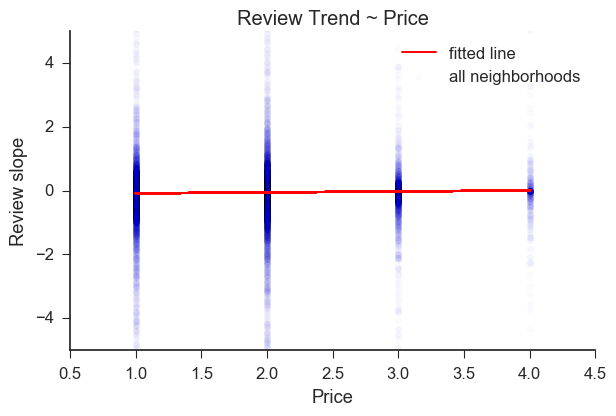

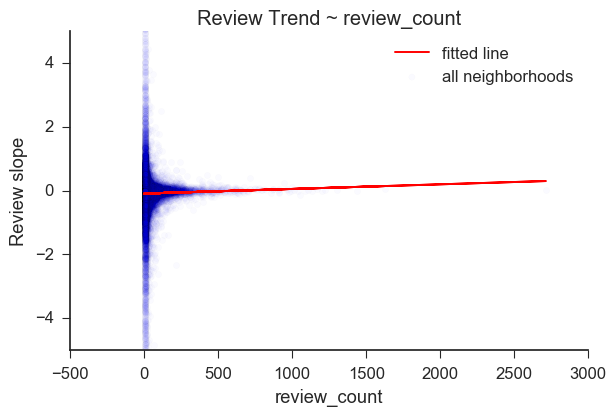

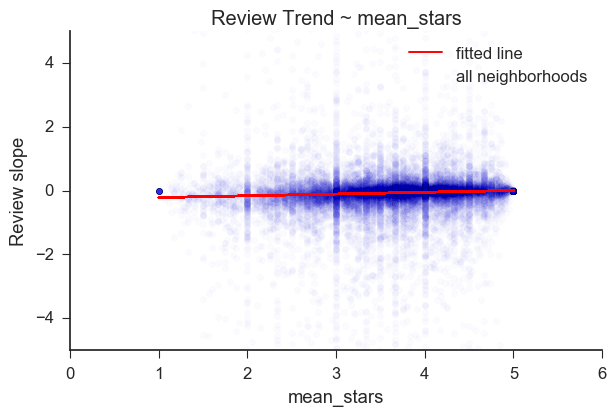

In [157]:
variables = ['Price', 'review_count', 'mean_stars']
var_models = [mrm, r_mrm, ms_mrm]

for i in range(len(variables)):
    plt.figure()
    plt.scatter(df[variables[i]], df['slope'], c = 'b', label = 'all neighborhoods', alpha = 0.02)
    plt.plot(df[variables[i]], var_models[i].predict(sm.add_constant(df[variables[i]])), c = 'r', label = 'fitted line')
    plt.legend()
    plt.title('Review Trend ~ '+variables[i])
    plt.xlabel(variables[i])
    plt.ylabel('Review slope')
    plt.ylim(-5,5)
    sns.despine()
    #plt.savefig('/Users/zihaoxu/Desktop/Review Trend~'+variables[i]+'.png', dpi = 300, fmt = 'png')


number of data poitns:  192


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


NameError: name 'color_list' is not defined

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


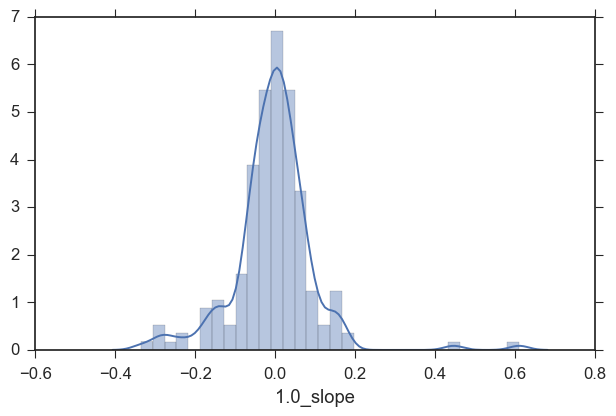

In [74]:
print ("number of data poitns: ", len(nzy))
for price in price_list:
    sns.distplot(nzy[price+'_slope'].dropna(), label = price)
    plt.axvline(np.median(nzy[price+'_slope'].dropna()), linestyle = 'dashed', c = color_list[price_list.index(price)])

plt.xlim(-.5,.5)
plt.title('ALL: Review slope dist. for businesses w/ different dollar signs')
plt.xlabel('review trend')
plt.ylabel('density')
plt.legend()
sns.despine()

In [98]:
d['B_F'] = defaultdict(list)
d['B_F']['Price'] = price_list

for price in price_list:
    df = d['NRB'][d['NRB']['Price']==price]
    d['B_F']['means'].append(np.mean(df['stars']))
    mrm = linear_model.LinearRegression()
    mrm.fit(df['year'].reshape(len(df['year']),1), df['stars'].reshape(len(df['stars']),1))
    d['B_F']['slope'].append(mrm.coef_)
    d['B_F']['num'].append(len(df))
d['B_F'] = pd.DataFrame(d['B_F'])

In [99]:
d['B_F']

,Price,means,num,slope
0,1.0,3.816656,200585,[[0.00443559507564]]
1,2.0,3.804697,440310,[[0.018989481368]]
2,3.0,3.818003,53781,[[-0.00918539135321]]
3,4.0,3.761518,6533,[[-0.0600945824499]]


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


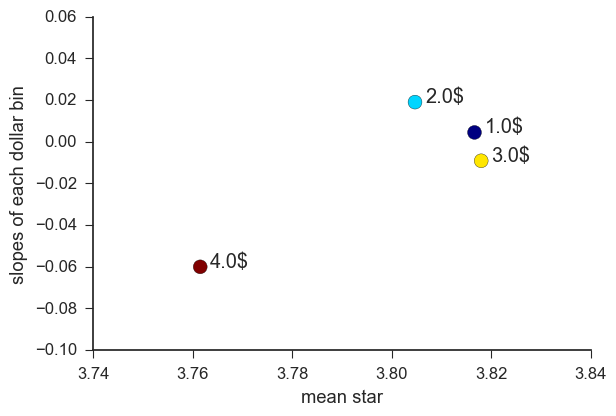

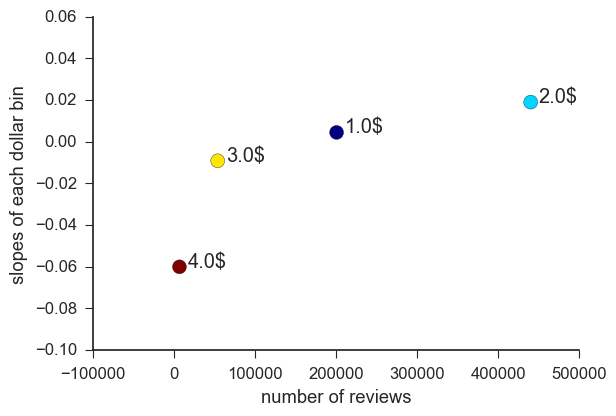

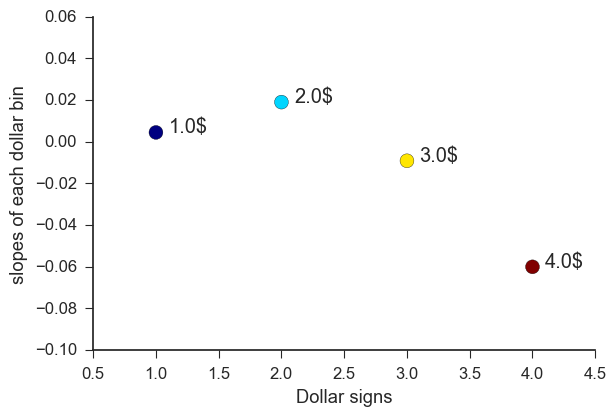

In [167]:
plt.scatter(d['B_F']['means'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.xlabel('mean star')
plt.ylabel('slopes of each dollar bin')
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['means']+0.002,temp['slope']+0.00002))

sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/slope_mean_stars.png', dpi = 300, fmt = 'png')

plt.figure()
plt.scatter(d['B_F']['num'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.xlabel('number of reviews')
plt.ylabel('slopes of each dollar bin')
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['num']+10000,temp['slope']+0.00002))
sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/slope_num_reviews.png', dpi = 300, fmt = 'png')


plt.figure()
plt.scatter(d['B_F']['Price'], d['B_F']['slope'], c = d['B_F']['Price'], cmap = 'jet',s=100)
plt.xlabel('Dollar signs')
plt.ylabel('slopes of each dollar bin')
for price in price_list:
    temp = d['B_F'][d['B_F']['Price']==price]
    plt.annotate(str(price)+'$', xy=(temp['Price']+.1,temp['slope']+0.00002))
sns.despine()
#plt.savefig('/Users/zihaoxu/Desktop/slope_dollar_sign.png', dpi = 300, fmt = 'png')